### Regresión Logística - Pair programming ###

## 1. EDA ##

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd


# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns


#  Gestión de warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

Para los ejercicios de pair programming de Regresión logística tendremos que buscar un dataset (al igual que hicismos en regresión lineal) que usaremos a lo largo de los siguientes ejercicios.

Se ruega a la hora de realizar la entrega que incluyais el conjunto de datos que hayais decidido emplear para estos ejercicios.

Objetivos

Buscar un conjunto de datos a analizar

Se recomienda que el conjunto de datos a analizar tenga variables numéricas y categóricas, primando que haya más de una variable de tipo numérico.

Explicar los datos y las variables disponibles en el conjunto de datos seleccionado

Realizar un EDA sencillo poniendo en práctica los conocimientos adquiridos hasta el momento.

Interpretación de los resultados.

In [2]:
df = pd.read_csv("data/card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


El dataset elegido es "Credit Card Fraud", las columnas que contienen son:

- distance_from_home: distancia desde casa adonde ocurrió la transacción.
- distance_from_last_transaction: distancia desde donde ocurrió la última transacción.
- ratio_to_median_purchase_price: ratio entre el precio de compra de la transacción y el precio medio de compra.
- repeat_retailer: si la transacción ocurrió en el mismo establecimiento (0: No, 1: Sí)
- used_chip: si la transacción ocurrió con tarjeta de crédito (0: No, 1: Sí)
- used_pin_number: si la transacción ocurrió usando el número PIN (0: No, 1: Sí)
- online_order: si la transacción ocurrió online (0: No, 1: Sí)
- fraud: si la transacción es fraudulenta (0: No, 1: Sí)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

Vemos que no tenemos ni nulos ni duplicados.

In [6]:
correlacion = df.corr()
correlacion

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,0.000193,-0.001374,0.143124,-0.000697,-0.001622,-0.001301,0.187571
distance_from_last_transaction,0.000193,1.000000,0.001013,-0.000928,0.002055,-0.000899,0.000141,0.091917
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000,0.001374,0.000587,0.000942,-0.000330,0.462305
repeat_retailer,0.143124,-0.000928,0.001374,1.000000,-0.001345,-0.000417,-0.000532,-0.001357
used_chip,-0.000697,0.002055,0.000587,-0.001345,1.000000,-0.001393,-0.000219,-0.060975
used_pin_number,-0.001622,-0.000899,0.000942,-0.000417,-0.001393,1.000000,-0.000291,-0.100293
online_order,-0.001301,0.000141,-0.000330,-0.000532,-0.000219,-0.000291,1.000000,0.191973
fraud,0.187571,0.091917,0.462305,-0.001357,-0.060975,-0.100293,0.191973,1.000000


Por lo que vemos, la variable que más correlación tiene con "fraud" es "ratio_to_median_purchase_price" con un valor de 0.462305, seguida de "online_order" con 0.191973 y "distance_from_home" con 0.187571.

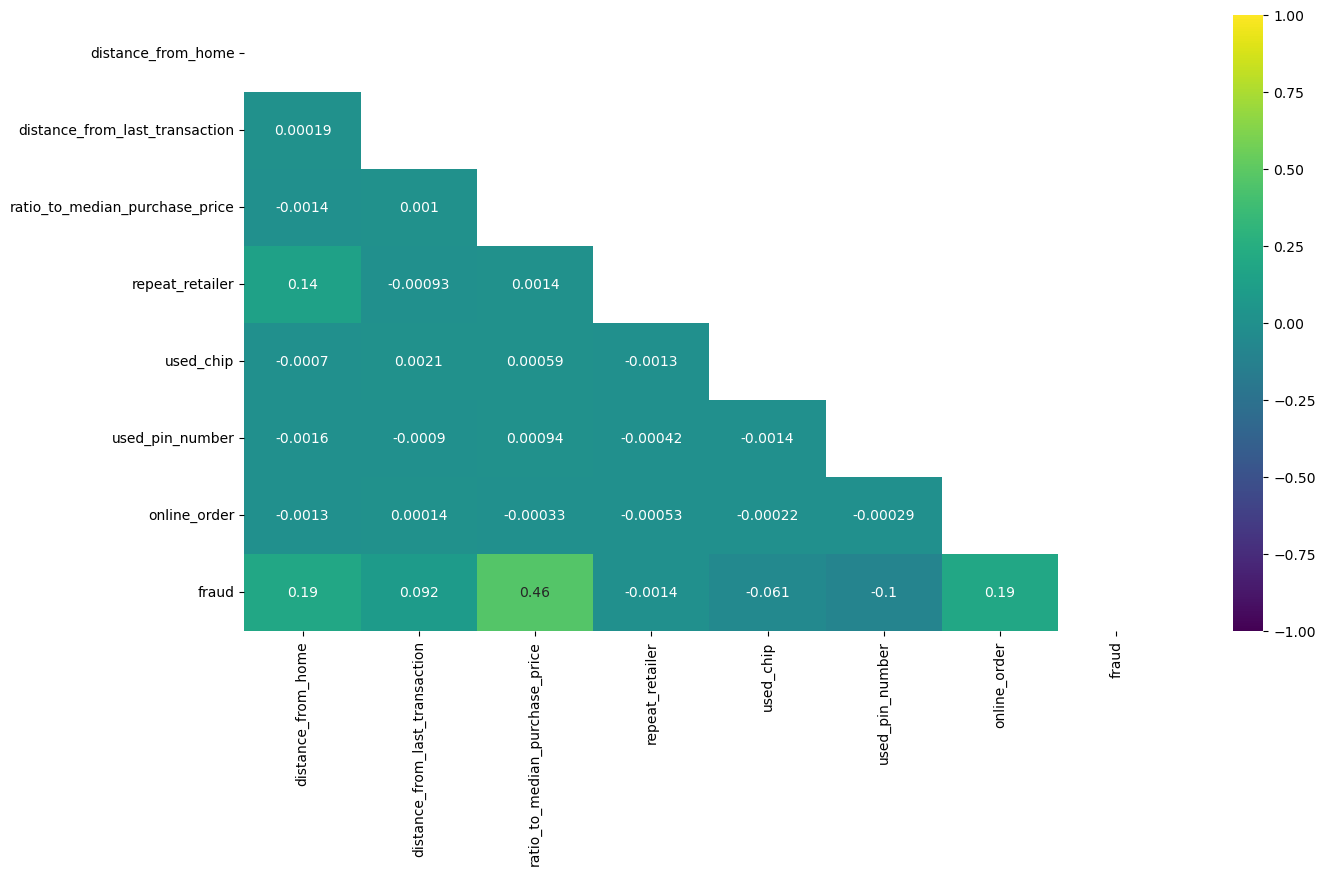

In [7]:
plt.figure(figsize=(15,8))
mask = np.triu(np.ones_like(correlacion, dtype=bool))
sns.heatmap(correlacion, cmap="viridis", annot = True, mask=mask, vmin = -1, vmax=1);

Podemos observar que todas nuestras variables son independientes

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,3.878008,9.967760,25.743985,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.296671,0.998650,3.355748,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.475673,0.997717,2.096370,267.802942
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


Vemos que en las variables numéricas tendremos outliers, que los estudiaremos más adelante.

In [9]:
df["fraud"].value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

In [10]:
df["online_order"].value_counts()

1.0    650552
0.0    349448
Name: online_order, dtype: int64

In [11]:
df["used_pin_number"].value_counts()

0.0    899392
1.0    100608
Name: used_pin_number, dtype: int64

In [12]:
df["used_chip"].value_counts()

0.0    649601
1.0    350399
Name: used_chip, dtype: int64

In [13]:
df["repeat_retailer"].value_counts()

1.0    881536
0.0    118464
Name: repeat_retailer, dtype: int64

Cambiamos las columnas a categóricas porque no consideramos que sean numéricas.

In [24]:
columnas_cat = ["used_chip", "repeat_retailer", "online_order", "used_pin_number", "fraud"]
for columna in columnas_cat:
    df[columna] = df[columna].astype("category")

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype   
---  ------                          --------------    -----   
 0   distance_from_home              1000000 non-null  float64 
 1   distance_from_last_transaction  1000000 non-null  float64 
 2   ratio_to_median_purchase_price  1000000 non-null  float64 
 3   repeat_retailer                 1000000 non-null  category
 4   used_chip                       1000000 non-null  category
 5   used_pin_number                 1000000 non-null  category
 6   online_order                    1000000 non-null  category
 7   fraud                           1000000 non-null  category
dtypes: category(5), float64(3)
memory usage: 27.7 MB


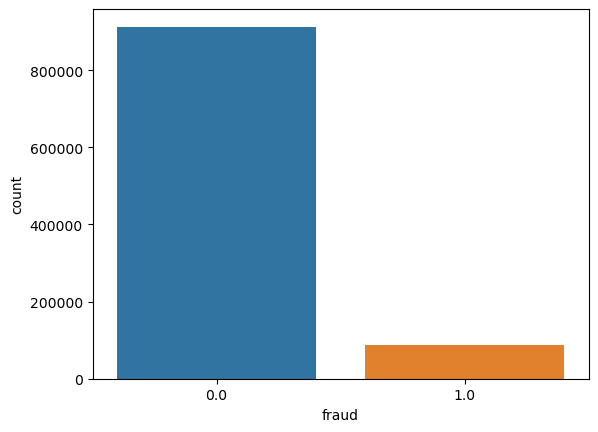

In [27]:
#Gráfica para ver la variable respuesta
sns.countplot(data= df, x = "fraud");

Por lo que vemos, nuestra VR está muy desbalanceada.

In [28]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [29]:
df.groupby('fraud')['distance_from_home'].mean().reset_index()

,fraud,distance_from_home
0,0.0,22.832976
1,1.0,66.261876


In [30]:
df.groupby('fraud')['distance_from_home'].median().reset_index()

,fraud,distance_from_home
0,0.0,9.673847
1,1.0,15.454219


In [31]:
df.groupby('fraud')['distance_from_last_transaction'].mean().reset_index()

,fraud,distance_from_last_transaction
0,0.0,4.301391
1,1.0,12.712185


In [32]:
df.groupby('fraud')['ratio_to_median_purchase_price'].median().reset_index()

,fraud,ratio_to_median_purchase_price
0,0.0,0.913950
1,1.0,5.071294


Hemos observado que hay ciertos patrones que se repiten, como que las compras fraudulentas se hacen a más distancia, en compras online y con una diferencia de importe.

IndexError: index 4 is out of bounds for axis 0 with size 4

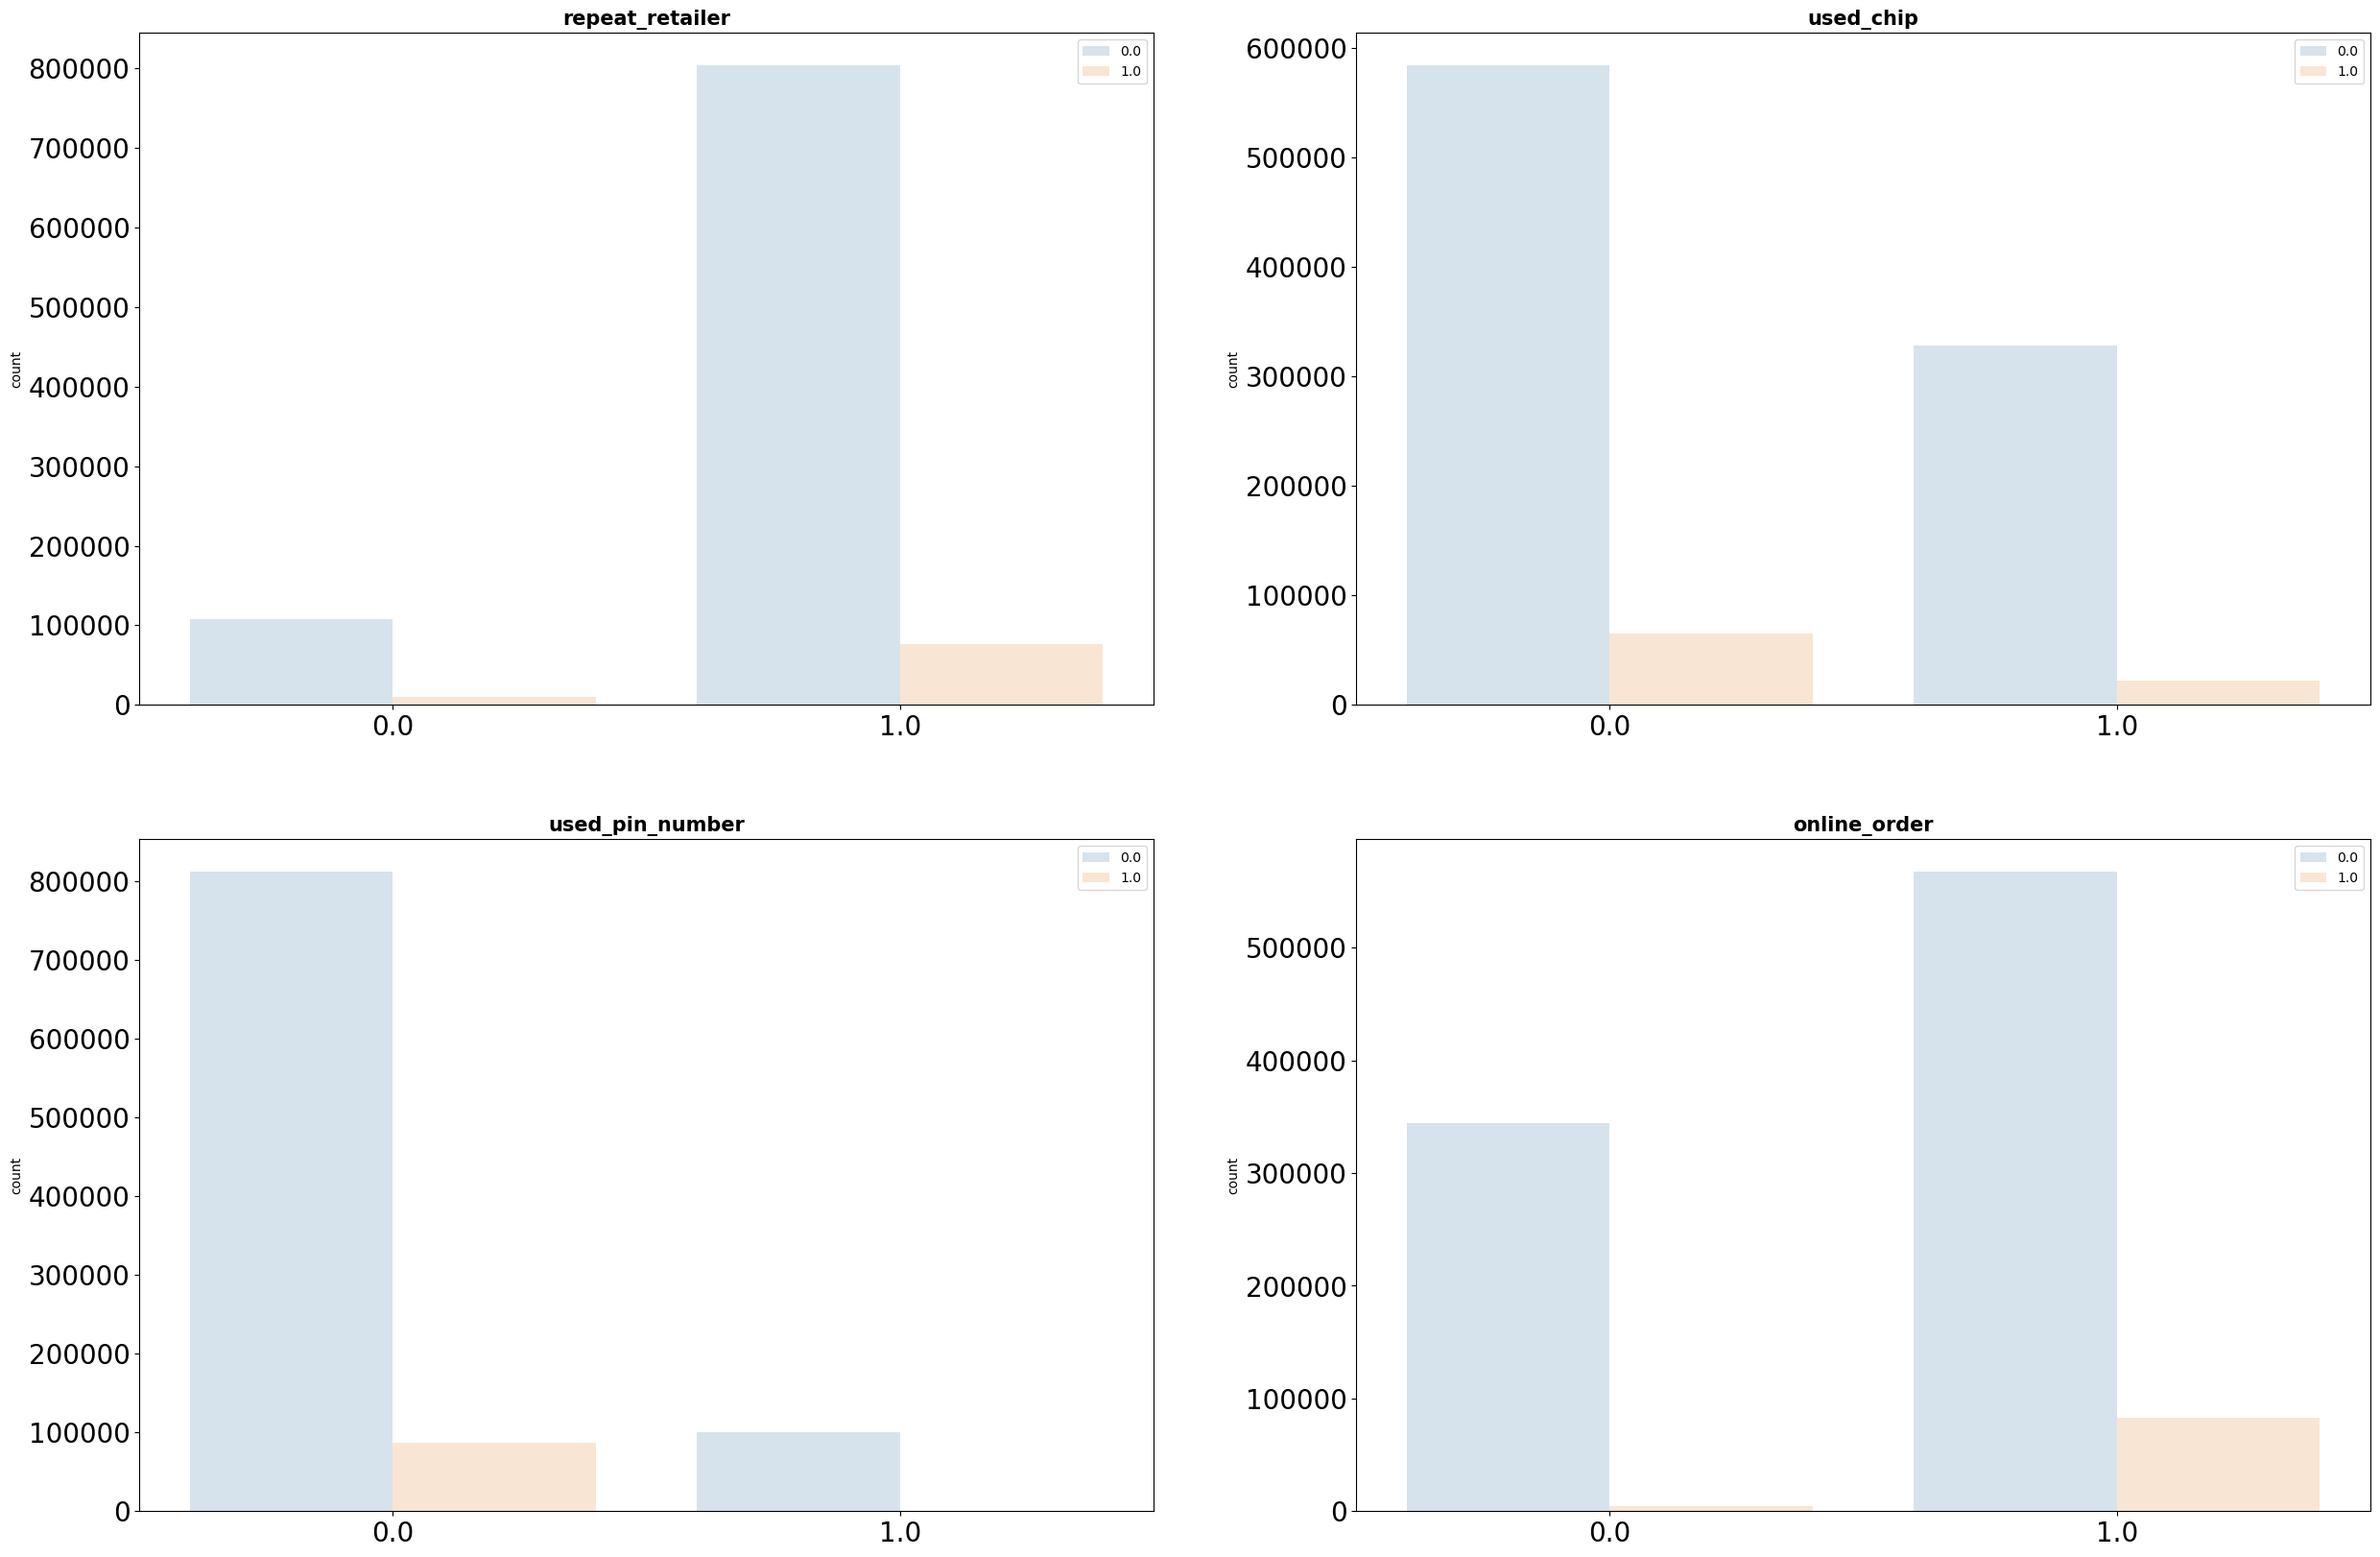

In [37]:

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 20))

axes = axes.flat
columnas_cat = df.select_dtypes(exclude = np.number).columns

for i, colum in enumerate(columnas_cat): 
    sns.countplot(
        data = df,
        x = colum,
        hue = "fraud",
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].legend(loc= "upper right")

fig.tight_layout();

De estos gráficos deducimos que los fraudes mayoritariamente suelen ser en compras recurrentes, compras online y sin usar el número pin.

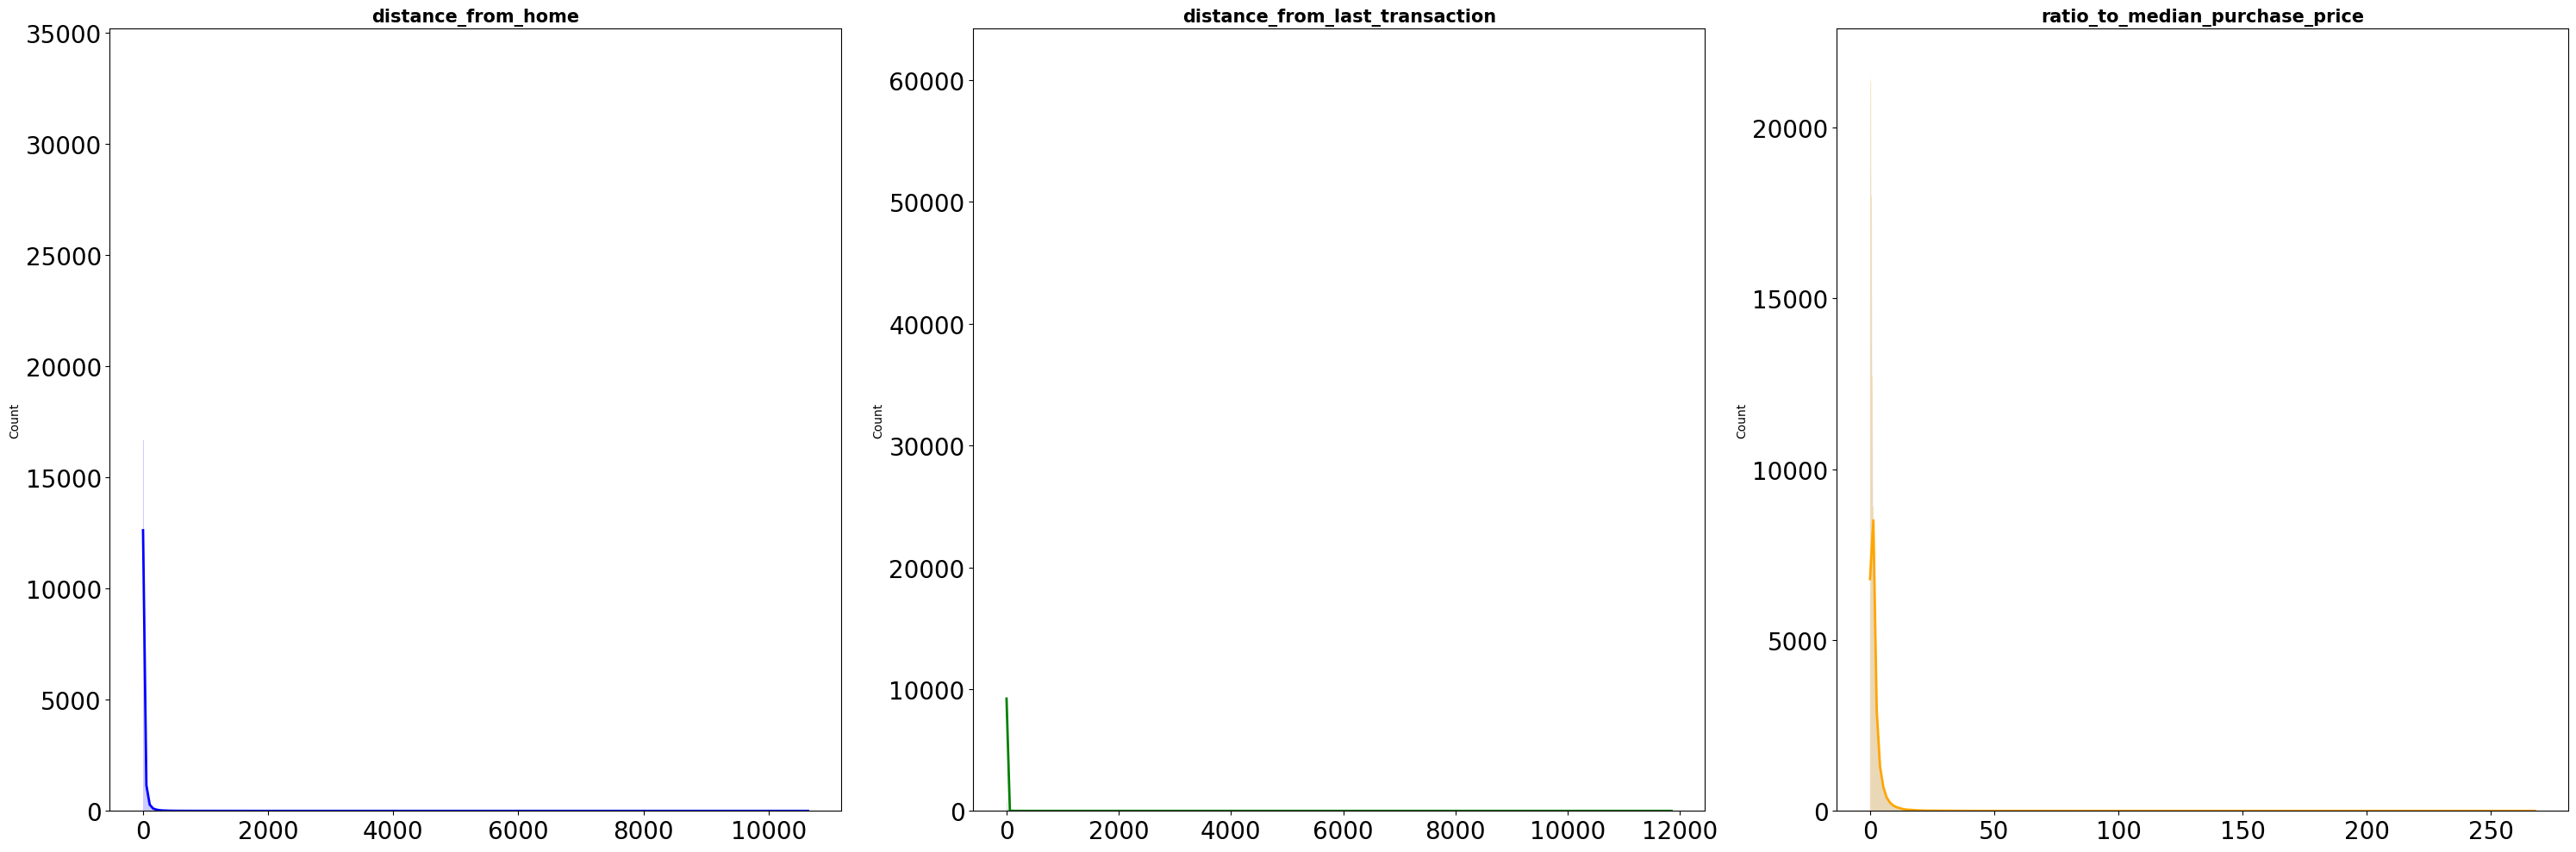

In [38]:

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

lista_colores = ["blue", "green", "orange"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df,
        x = colum,
        kde = True, 
        color = lista_colores[i], 
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    
fig.tight_layout();

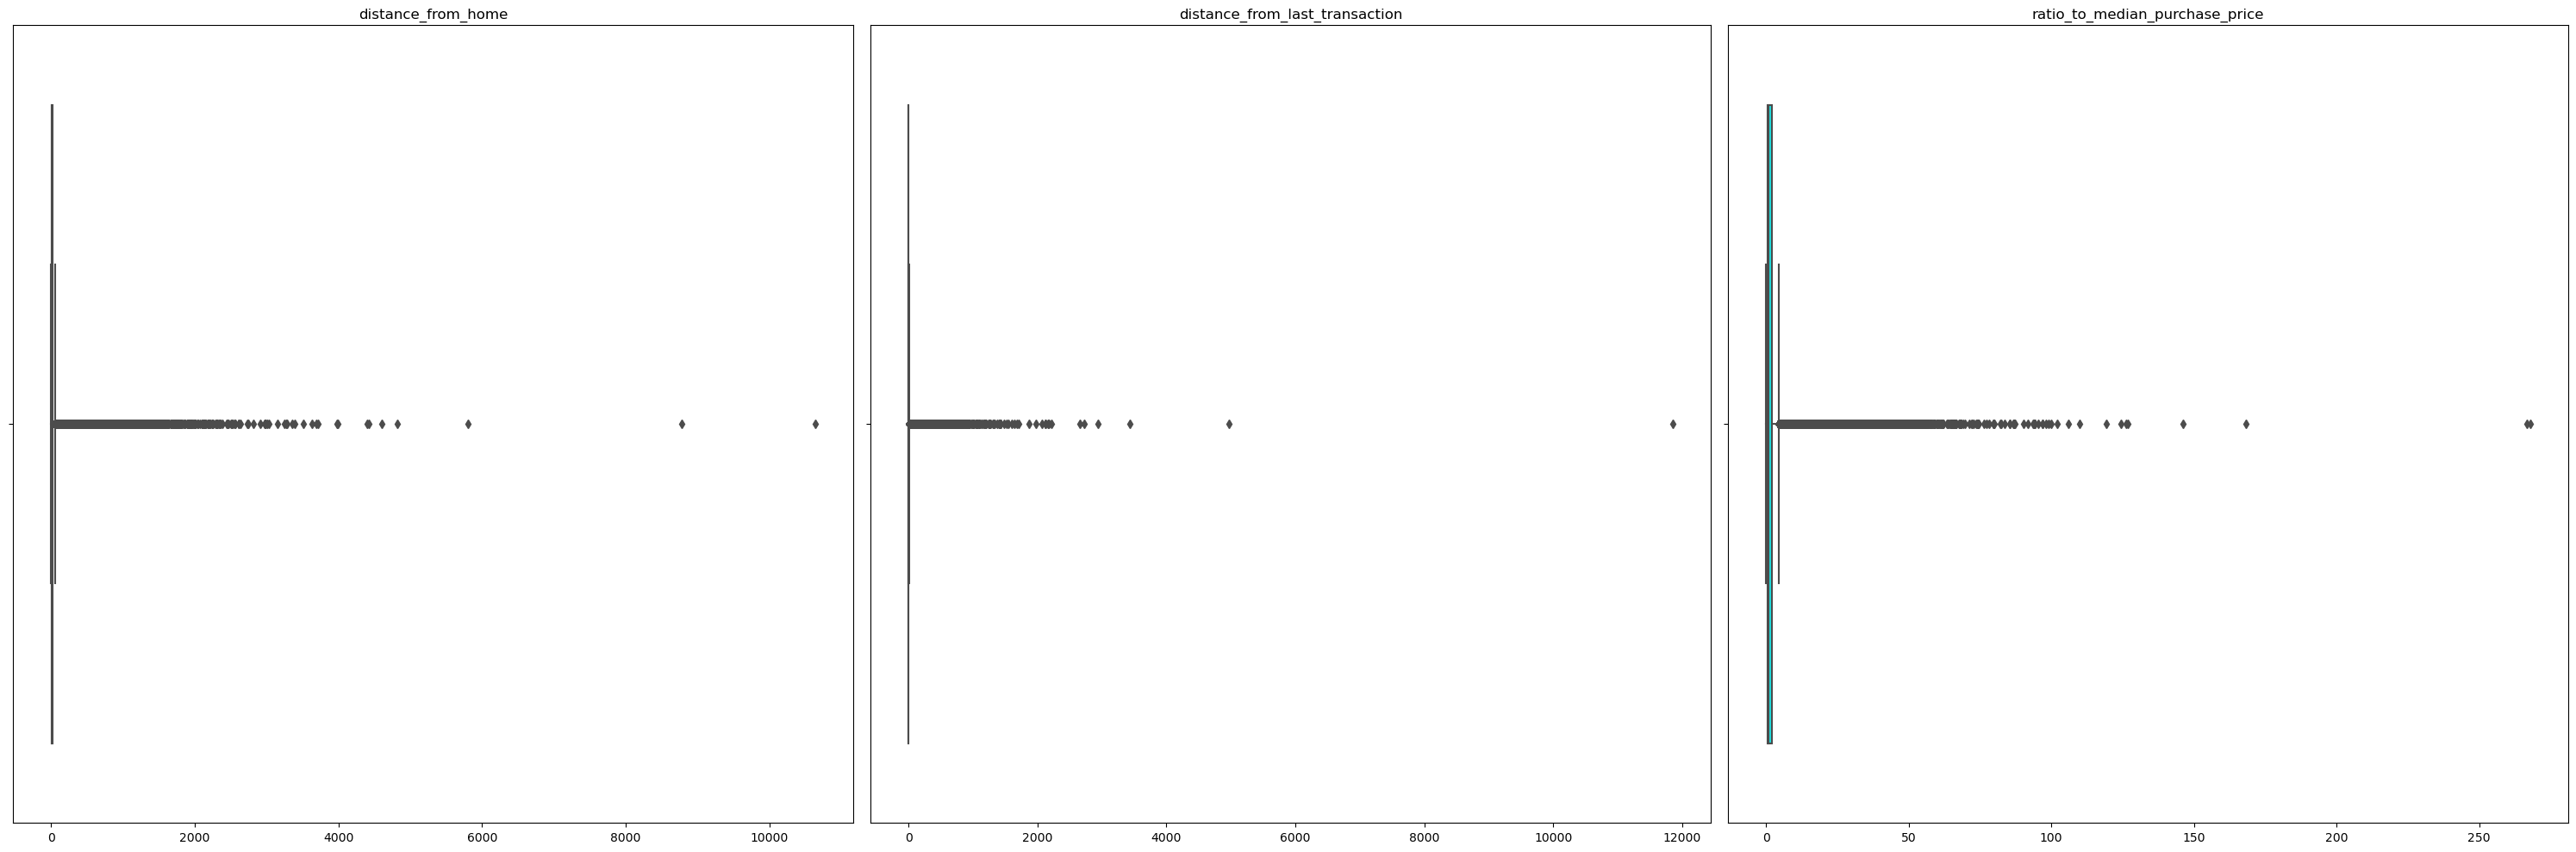

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))

categorias = df.select_dtypes(include = np.number).columns

axes = axes.flat

for indice, cate in enumerate(categorias):

    sns.boxplot(x = df[cate], data = df, ax=axes[indice], color = "cyan")

    axes[indice].set_title(cate)
    axes[indice].set_xlabel("")

fig.tight_layout();

In [41]:
df.head(1)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.31114,1.94594,1.0,1.0,0.0,0.0,0.0


In [42]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 

In [47]:
ind = detectar_outliers(['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'], df)

In [44]:
valores = ind.values()
valores = {indice for sublista in valores for indice in sublista}
valores

{524290,
 5,
 524295,
 524296,
 12,
 13,
 15,
 16,
 18,
 524306,
 20,
 524308,
 524309,
 24,
 524315,
 28,
 29,
 30,
 524319,
 33,
 524323,
 35,
 37,
 36,
 39,
 524327,
 524332,
 47,
 48,
 524338,
 524341,
 54,
 524345,
 59,
 524347,
 524350,
 63,
 64,
 524352,
 69,
 524359,
 73,
 74,
 75,
 524363,
 524365,
 524369,
 92,
 524380,
 96,
 101,
 106,
 524397,
 524398,
 524399,
 112,
 524400,
 524402,
 115,
 524404,
 524405,
 524408,
 524409,
 524412,
 125,
 126,
 524413,
 524416,
 524417,
 524420,
 133,
 524422,
 524423,
 136,
 524424,
 524426,
 524428,
 524433,
 150,
 155,
 156,
 524444,
 524446,
 159,
 524449,
 163,
 524452,
 524456,
 524457,
 174,
 524463,
 524469,
 524473,
 186,
 524475,
 187,
 524477,
 196,
 199,
 202,
 524490,
 205,
 524493,
 524495,
 524496,
 524498,
 212,
 524503,
 218,
 524506,
 220,
 524508,
 222,
 524512,
 524513,
 225,
 229,
 231,
 232,
 233,
 524522,
 235,
 524524,
 524525,
 237,
 524519,
 524526,
 524529,
 242,
 243,
 241,
 524528,
 524530,
 247,
 524536,
 52

In [49]:
df_outliers = df[df.index.isin(valores)]
df_outliers.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
12,765.282559,0.371562,0.551245,1.0,1.0,0.0,0.0,0.0
13,2.131956,56.372401,6.358667,1.0,0.0,0.0,1.0,1.0
15,179.665148,0.120920,0.535640,1.0,1.0,1.0,1.0,0.0
16,114.519789,0.707003,0.516990,1.0,0.0,0.0,0.0,0.0


In [50]:
df_outliers['fraud'].value_counts()

0.0    202887
1.0     78363
Name: fraud, dtype: int64

Decidimos no hacer nada con los outliers, ya que la información que nos proporcionan es muy importante.

In [51]:
df.to_pickle("data/card_limpio.pkl")